# Drug Resistance in Pf7 vs Pf8

## Introduction

In Pf8, drug resistance phenotypes inferred with a heuristic framework linking genetic variation in *crt*, *mdr1*, *dhfr*, *dhps*, *pm2*, *pm3* and *kelch13* to ‘Resistant’, ‘Sensitive’, or ‘Undetermined’ status for major antimalarials. The rules are based on current understanding and available data on the molecular mechanisms of drug resistance in *P. falciparum*  (rules can be accessed [here](https://pf8-release.cog.sanger.ac.uk/Pf8_resistance_classification.pdf)).

Updates to the coverage-based method in the Pf8 copy-number variation (CNV) calling pipeline have led to changes in the inferred resistance status of some Pf7 samples (see Pf8 supplementary for details). This notebook quantifies these changes and compares the overall prevalence of resistant samples across Pf7 and Pf8 data resources.

This notebook will generate the following three figures:

*   A bar plot showing number of samples with any change in inferred drug resistance status from Pf7 to Pf8
*   Heatmaps showing number of samples with inferred drug resistance status between Pf7 and Pf8, across the 15,999 overlapping samples
*   A grouped bar plot showing percentage of parasites with inferred ‘Resistant’ status in Pf7 and Pf8, for each drug in the collection.

**This notebook should take approximately two minutes to run.**





## Setup

Import required python libraries installed at colab by default.

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import numpy as np
import collections
import re
import scipy
from google.colab import drive

## Access Pf8 Inferred Resistance Status of Pf7 and Pf8 Samples



We can access the Pf7 resistance status file on MalariaGEN website and Pf8 version of this file on Sanger's cloud.

In [ ]:
df_pf7 = pd.read_csv('https://www.malariagen.net/wp-content/uploads/2023/11/Pf7_inferred_resistance_status_classification.txt', sep='\t')
print(df_pf7.shape)

df_pf8 = pd.read_csv('https://pf8-release.cog.sanger.ac.uk/Pf8_inferred_resistance_status_classification.tsv', sep='\t')
print(df_pf8.shape)

(16203, 14)
(24409, 11)


Only QC-pass samples were used for prediction of resistance status. Let's look how the dataset looks like.

In [ ]:
df_pf8.head()

,sample,Chloroquine,Pyrimethamine,Sulfadoxine,Mefloquine,Artemisinin,Piperaquine,SP (uncomplicated),SP (IPTp),AS-MQ,DHA-PPQ
0,FP0008-C,Undetermined,Undetermined,Undetermined,Sensitive,Sensitive,Sensitive,Sensitive,Sensitive,Sensitive,Sensitive
1,FP0009-C,Resistant,Resistant,Sensitive,Sensitive,Sensitive,Sensitive,Resistant,Sensitive,Sensitive,Sensitive
2,FP0010-CW,Undetermined,Resistant,Resistant,Sensitive,Sensitive,Sensitive,Resistant,Sensitive,Sensitive,Sensitive
3,FP0011-CW,Undetermined,Resistant,Undetermined,Sensitive,Sensitive,Sensitive,Resistant,Sensitive,Sensitive,Sensitive
4,FP0012-CW,Resistant,Resistant,Sensitive,Sensitive,Sensitive,Sensitive,Resistant,Sensitive,Sensitive,Sensitive


### Figure Preparations

To prepare the dataset for the figure, we will start with doing some minor adjustments in the column names.

In [ ]:
# Rename SP (uncomplicated) to SP (treatment)
df_pf8.rename(columns={"SP (uncomplicated)": "SP (treatment)", "sample":"Sample"}, inplace=True)
df_pf7.rename(columns={"SP (uncomplicated)": "SP (treatment)"}, inplace=True)

Now, let's make sure column names between the Pf7 and Pf8 datasets are consistent. This will allow succesful merging of these datasets in the next step.

In [ ]:
# Identify columns common to both Pf7 and Pf8 datasets (excluding 'sample')
common_columns = [col for col in df_pf8.columns if col in df_pf7.columns and col != "Sample"]

Merging the data will allow easier access when plotting. The suffixes `_Pf8` and `_Pf7` will help differentiate columns for each dataset.

In [ ]:
# Merge the datasets on the 'sample' column
merged_df = pd.merge(df_pf8, df_pf7, on="Sample", suffixes=('_Pf8', '_Pf7'))

Finally, we will find out the number of samples which have changed inferred resistance status for each drug. In addition to shifts between "Resistant" to "Sensitive", we will also count shifts involving "Undetermined" status such as "Undetermined" to "Sensitive".

In [ ]:
# Initialize statistics
change_counts = []
total_samples = len(merged_df)

# Compute change statistics for each column
for col in df_pf8.columns:
    if col == "Sample":  # Skip the 'sample' column
        continue
    if col in df_pf7.columns:  # Only compare columns present in both datasets
        col1 = merged_df[f"{col}_Pf8"]
        col2 = merged_df[f"{col}_Pf7"]

        # Count changes between Resistant and Sensitive
        resistance_changes = ((col1 == "Resistant") & (col2 == "Sensitive")) | ((col1 == "Sensitive") & (col2 == "Resistant"))
        resistance_changes_count = resistance_changes.sum()

        # Count changes involving 'Undetermined'
        undetermined_changes = ((col1 == "Undetermined") & (col2 != "Undetermined")) | ((col1 != "Undetermined") & (col2 == "Undetermined"))
        undetermined_changes_count = undetermined_changes.sum()

        change_counts.append({
            "Drug": col,
            "Changes in Resistance status": resistance_changes_count,
            "Callable to Uncallable": undetermined_changes_count,
            "Total Samples": total_samples
        })

# Convert to DataFrame
change_counts_df = pd.DataFrame(change_counts)
change_counts_df.head(3)

,Drug,Changes in Resistance status,Callable to Uncallable,Total Samples
0,Chloroquine,0,130,15999
1,Pyrimethamine,0,63,15999
2,Sulfadoxine,0,72,15999


## Bar Plot: Total number of changes in resistance status between Pf7 and Pf8

We will create a grouped bar plot where there will be one bar showing the number of changes in resistance status and changes in callable status (Undetermined ⇆) for each drug.

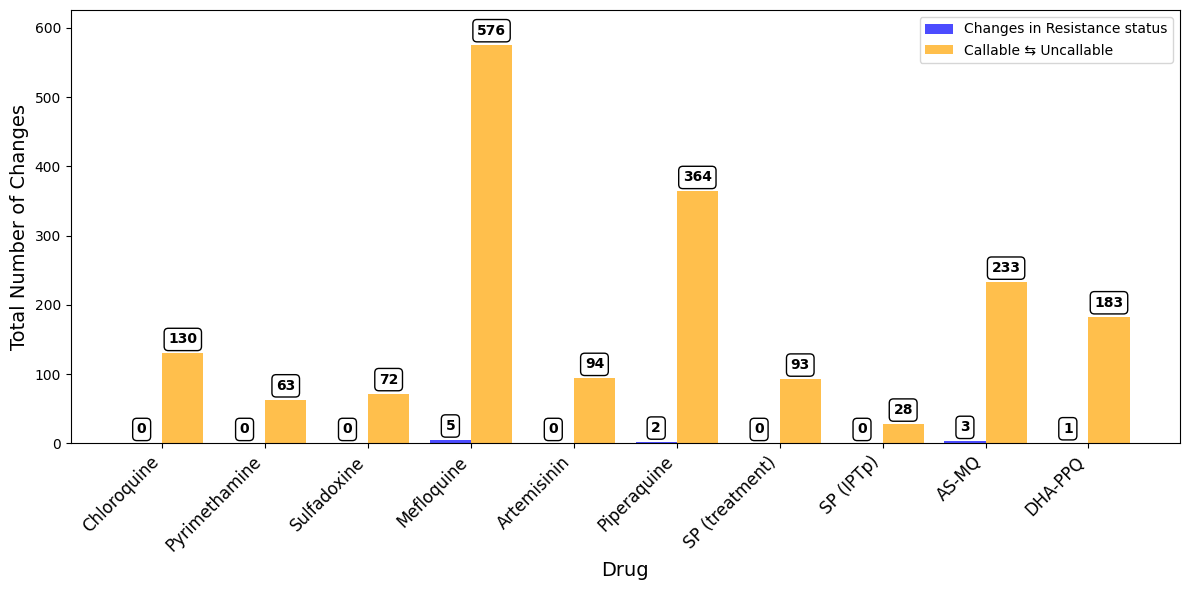

In [ ]:
# Plot the changes with labels inside white boxes
fig, ax = plt.subplots(figsize=(12, 6))

# Define bar positions
x = range(len(change_counts_df))
bar_width = 0.4

# Plot bars
bars1 = ax.bar([pos - bar_width/2 for pos in x], change_counts_df["Changes in Resistance status"], width=bar_width, color="blue", alpha=0.7, label="Changes in Resistance status")
bars2 = ax.bar([pos + bar_width/2 for pos in x], change_counts_df["Callable to Uncallable"], width=bar_width, color="orange", alpha=0.7, label="Callable ⇆ Uncallable")

# Extend y-axis
ax.set_ylim(0, max(change_counts_df[["Changes in Resistance status", "Callable to Uncallable" ]].max()) + 50)

# Add labels above each bar
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2, height + 10, f"{int(height)}",
            ha="center", va="bottom", fontsize=10, fontweight="bold",
            bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3")
        )

ax.set_xticks(x)
ax.set_xticklabels(change_counts_df["Drug"], rotation=45, ha="right", fontsize=12)
ax.set_ylabel("Total Number of Changes", fontsize=14)
ax.set_xlabel("Drug", fontsize=14)
ax.legend()
plt.tight_layout()

**Figure Legend. Total number of samples with any change in inferred drug resistance status from Pf7 to Pf8.** Blue bars to the left show changes in resistance status (i.e. Resistant to Sensitive or vice versa). Yellow bars to the right show changes between Uncallable to Resistant/Sensitive or vice versa.

### Save Figure

In [ ]:
# You will need to authorise Google Colab access to Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
fig.savefig("/content/drive/My Drive/pf8-barplot-drug-resistance-change.png", dpi = 500)

## Pf7 vs Pf8 Drug Resistance Status Concordance Heatmaps

It is time to visualise the changes in resistance status between the Pf7 and Pf8 datasets on a more granular level by creating heatmaps for each drug. The x-axis will represent the resistance status from the Pf7 dataset, while the y-axis Pf8. The heatmaps will display the how many samples moved between different status categories (e.g., "Resistant" to "Sensitive" or "Undetermined" to "Sensitive").

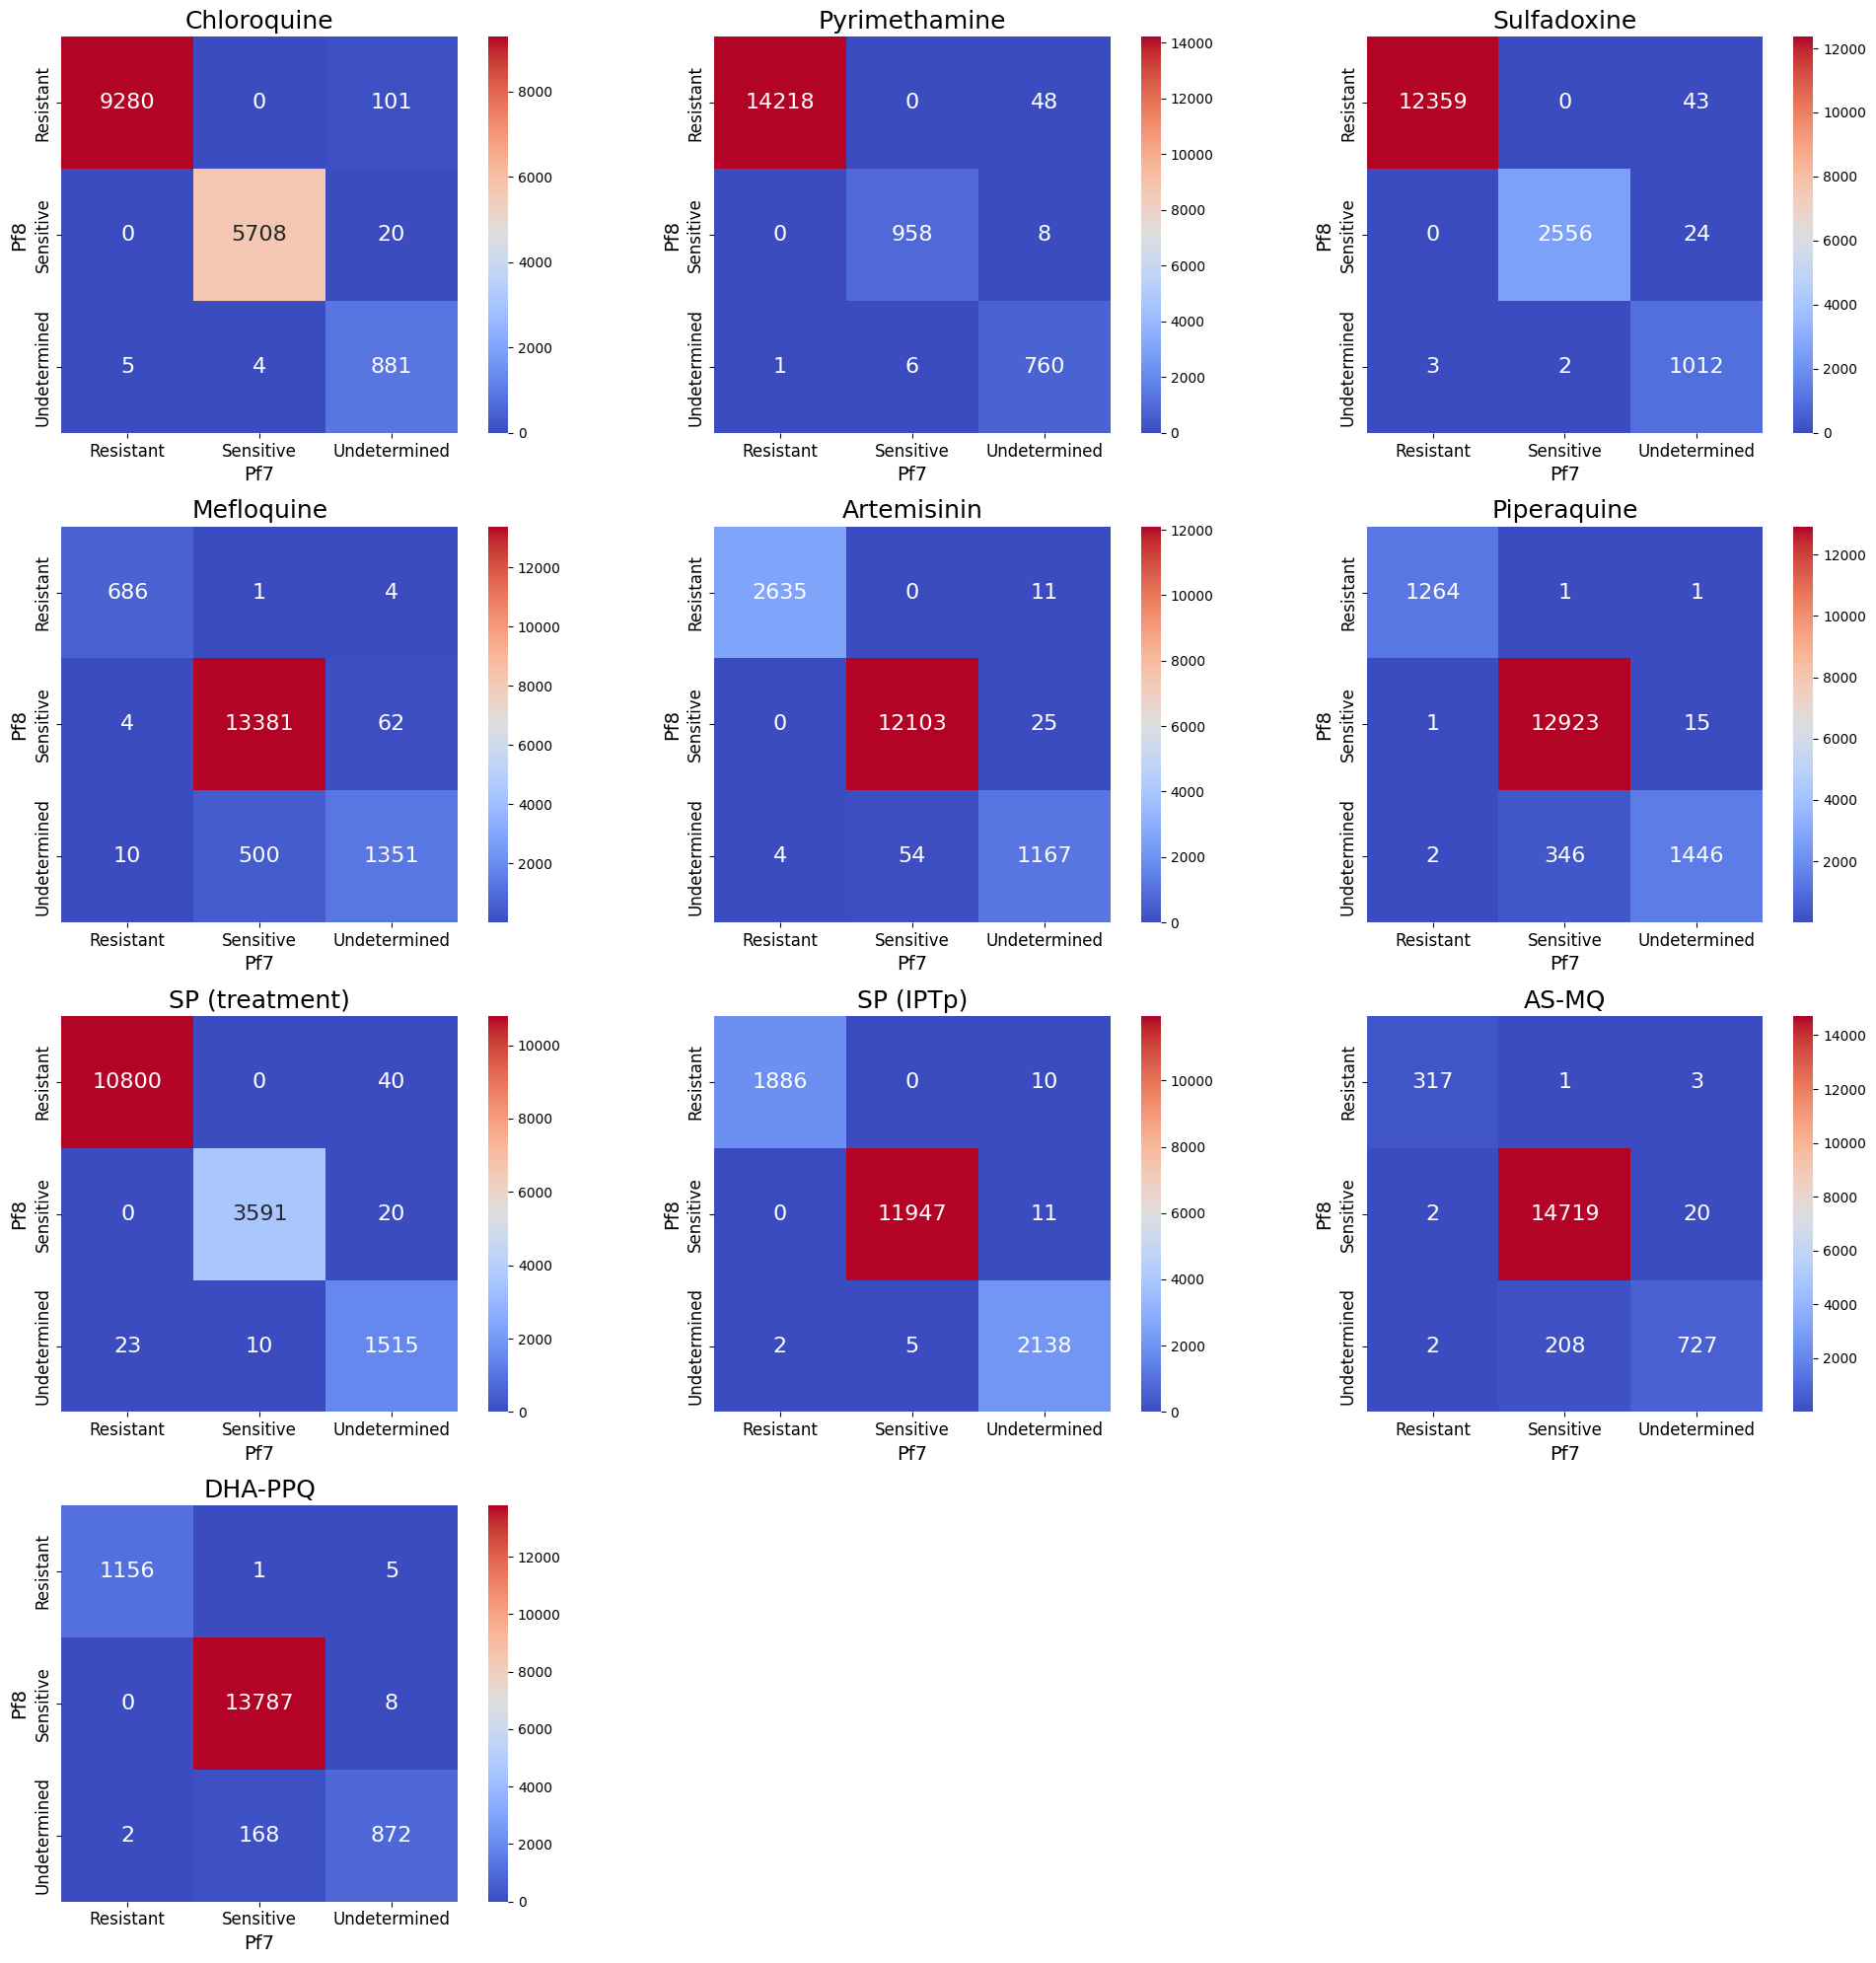

In [ ]:
# Initialize variables
heatmaps = []
change_summary = []

# Compute transition counts for each column
for col in common_columns:
    col_pf7 = merged_df[f"{col}_Pf7"]
    col_pf8 = merged_df[f"{col}_Pf8"]

    # Create a transition column
    merged_df[f"{col}_transition"] = col_pf7 + " -> " + col_pf8

    # Count transitions
    transitions = merged_df[f"{col}_transition"].value_counts()

    # Create confusion matrix-like structure
    categories = sorted(list(set(col_pf7.unique()).union(set(col_pf8.unique()))))
    confusion_matrix = pd.DataFrame(0, index=categories, columns=categories)

    for transition, count in transitions.items():
        from_cat, to_cat = transition.split(" -> ")
        confusion_matrix.loc[from_cat, to_cat] = count

    # Transpose the matrix to have Pf8 on rows and Pf7 on columns
    confusion_matrix = confusion_matrix.T

    # Calculate total changes (non-diagonal elements)
    total_changes = confusion_matrix.values.sum() - np.trace(confusion_matrix.values)
    change_summary.append({"Drug": col, "Total Changes": total_changes})

    # Append data for plotting
    heatmaps.append((col, confusion_matrix))

# Plot all heatmaps in a multipanel figure
n_cols = 3  # Adjust this for the number of columns in the figure
n_rows = -(-len(heatmaps) // n_cols)  # Calculate rows required
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

for i, (col, confusion_matrix) in enumerate(heatmaps):
    sns.heatmap(
        confusion_matrix,
        annot=True,
        fmt="d",
        cmap="coolwarm",
        cbar=True,
        square=True,
        ax=axes[i],
        annot_kws={"size": 16},  # Increase font size for annotations
    )
    axes[i].set_title(f"{col}", fontsize=18)
    axes[i].set_xlabel("Pf7", fontsize=14)  # Source: Pf7 dataset
    axes[i].set_ylabel("Pf8", fontsize=14)  # Destination: Pf8 dataset
    axes[i].tick_params(axis="both", labelsize=12)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Figure Legend. Total number of changes in inferred drug resistance status between Pf7 and Pf8, across the 15,999 overlapping samples.** Number and colour shading indicate the total number of samples for each category change. For example 43 samples had ‘Undetermined’ resistance status to Sulfadoxine in Pf7, but were ‘Resistant’ in Pf8. Samples on the diagonal therefore represent those with unchanged status between the two datasets.

### Save Figure

In [ ]:
fig.savefig('/content/drive/My Drive/all_confusion_matrices.png', dpi = 500)

## Percentage of resistant samples in Pf7 and Pf8

So far, we have observed changes in the **overlapping samples** between Pf7 and Pf8. What impact does this change in the status of some samples have on the **overall** prevalence of resistance? We are now focused on examining the prevalence of resistance in Pf7/Pf8. This will require calculating the prevalence of resistant samples first.

In [ ]:
# Calculate resistance proportions for Pf8
pf8_resistance_data = []
for drug in common_columns:
    filtered_pf8 = df_pf8[df_pf8[drug].isin(["Resistant", "Sensitive"])]
    total_samples_pf8 = len(filtered_pf8)
    resistant_samples_pf8 = filtered_pf8[filtered_pf8[drug] == "Resistant"]
    resistant_proportion_pf8 = int((len(resistant_samples_pf8) / total_samples_pf8) * 100) if total_samples_pf8 > 0 else 0
    pf8_resistance_data.append({"Drug": drug, "Pf": "Pf8", "Resistant Proportion": resistant_proportion_pf8})

# Calculate resistance proportions for Pf7
pf7_resistance_data = []
for drug in common_columns:
    filtered_pf7 = df_pf7[df_pf7[drug].isin(["Resistant", "Sensitive"])]
    total_samples_pf7 = len(filtered_pf7)
    resistant_samples_pf7 = filtered_pf7[filtered_pf7[drug] == "Resistant"]
    resistant_proportion_pf7 = int((len(resistant_samples_pf7) / total_samples_pf7) * 100) if total_samples_pf7 > 0 else 0
    pf7_resistance_data.append({"Drug": drug, "Pf": "Pf7", "Resistant Proportion": resistant_proportion_pf7})

# Combine the results
resistance_data = pf8_resistance_data + pf7_resistance_data
resistance_df = pd.DataFrame(resistance_data)

# Explicitly order the hue categories so Pf7 is always first
resistance_df["Pf"] = pd.Categorical(resistance_df["Pf"], categories=["Pf7", "Pf8"], ordered=True)

We will create a grouped bar plot, with one bar representing Pf7 and another representing Pf8 for each drug.

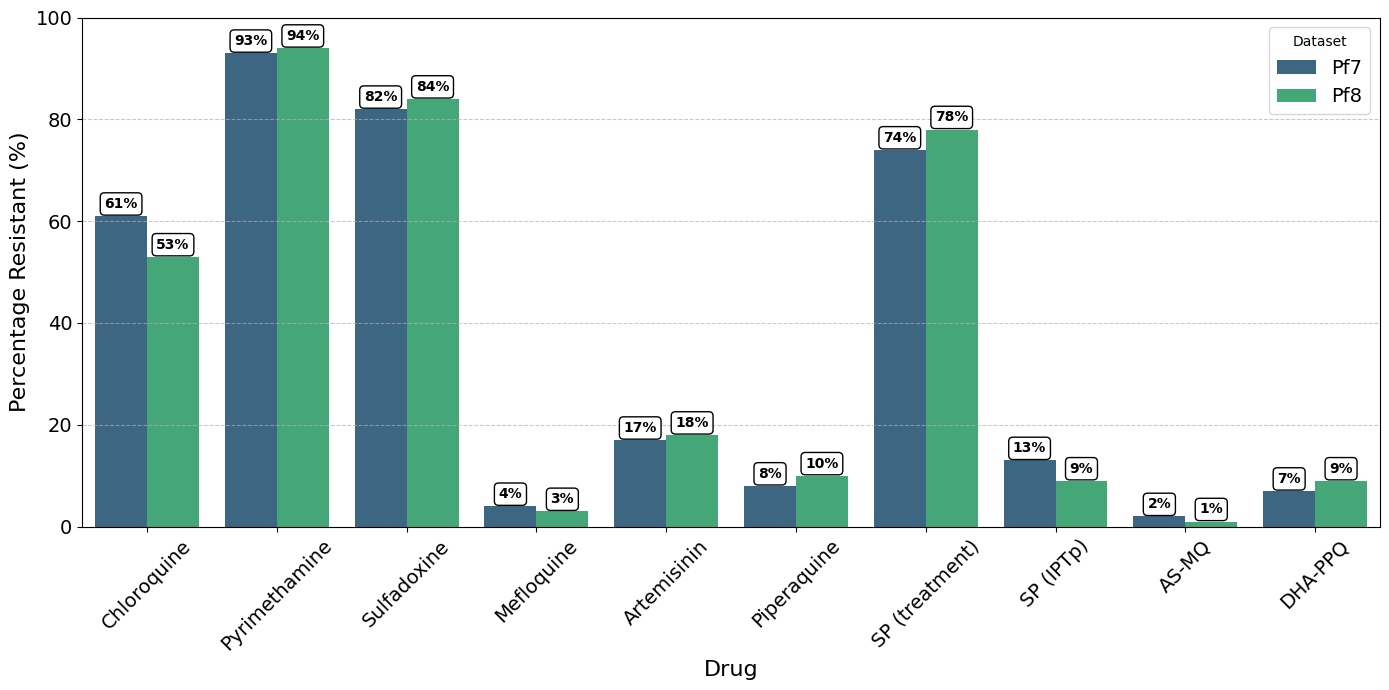

In [ ]:
 # Plot bar chart of resistance proportions for Pf8 and Pf7
fig, ax = plt.subplots(figsize=(14, 7))
sns.barplot(
    data=resistance_df,
    x="Drug",
    y="Resistant Proportion",
    hue="Pf",
    dodge=True,
    palette="viridis",
    ax=ax
)

# Add labels to each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Avoid placing labels on zero-value bars
        ax.annotate(f"{int(height)}%",  # Add '%' to each label
                    (p.get_x() + p.get_width() / 2, height + 1),  # Offset label slightly above bar
                    ha='center', va='bottom', fontsize=10, fontweight="bold",  # Reduce font size slightly
                    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"))

# Configure plot aesthetics with larger tick fonts
plt.xlabel("Drug", fontsize=16)
plt.ylabel("Percentage Resistant (%)", fontsize=16)
plt.xticks(rotation=45, fontsize=14)  # Increased tick font size
plt.yticks(fontsize=14)  # Increased y-axis tick font size
plt.legend(title="Dataset", fontsize=14)
plt.grid(axis="y", linestyle="--", linewidth=0.75, alpha=0.7)
plt.ylim(0, 100)  # Ensure space for labels at the top
plt.tight_layout()


**Figure Legend. Percentage of parasites with inferred ‘Resistant’ status in Pf7 and Pf8, for each drug in the collection, aggregated across all populations.** Note, samples with ‘Undetermined’ resistance status were excluded before calculating the relative proportion of ‘Resistant’ samples.


### Save Figure

In [ ]:
# Save the plot
fig.savefig('/content/drive/My Drive/resistant_proportion_comparison_bar_chart_corrected.png')